In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
from IPython.display import display #, HTML
from patsy import dmatrices
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colorbar 
import os
import seaborn as sns
%matplotlib inline
#%matplotlib notebook

In [5]:
df = pd.read_excel('measurements2.xlsx')
display(df.tail(6))

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
382,13.6,3.7,33,24.5,28,sun,SP98,0,0,1,NaN,NaN
383,16.0,3.7,39,24.5,18,NaN,SP98,0,0,0,NaN,NaN
384,16.1,4.3,38,25.0,31,AC,SP98,1,0,0,NaN,NaN
385,16.0,3.8,45,25.0,19,NaN,SP98,0,0,0,NaN,NaN
386,15.4,4.6,42,25.0,31,AC,SP98,1,0,0,NaN,NaN
387,14.7,5.0,25,25.0,30,AC,SP98,1,0,0,NaN,NaN


* distance is the distance in kilometers i was driving
* consume is the consumption in liters per 100 kilometers as seen in the display
* speed is the average speed.
temp_inside is the setting of the heating or "NaN" if it was turned off
* temp_outside is the temperature outside, taken at the end of the ride.
* specials is a remark if it was raining, snowing or if the climatization was on ("AC")
* gas type is the gas type used during the last refill
* AC is one hot encoded, the special "AC". 1 for on, 0 for off.
* rain is one-hot-encoded, the special "rain" and "snow". 1 for it was raining/snowing, 0 for it was good weather.
* I added a new feature in march: sun. This means it was sunny enough outside so that the car felt warm when i was getting into it. It's sad but this is the first month where i needed it. On the other hand it means that we missed nothing until now. :-)
<br/><br/>
Let's do some graphics.

**Plot of Speed in km/h vs consume in L/100km** 
<br/>
This plot show the fuel consumption according to Speed in km/h.

Text(0, 0.5, 'consume in L/100km')

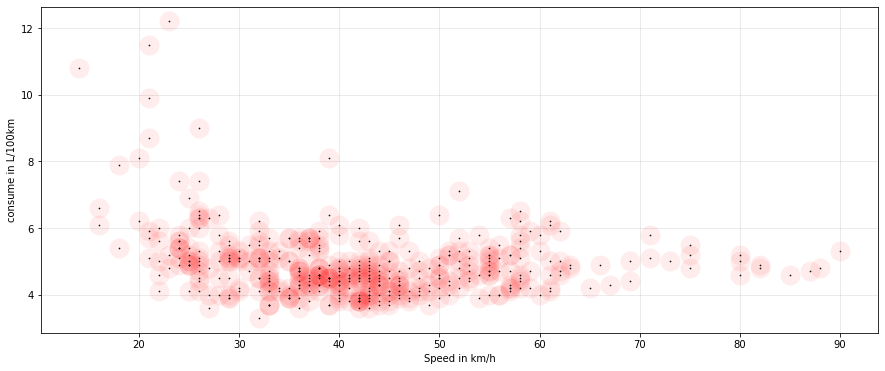

In [6]:
fig, axarr = plt.subplots()
fig.set_size_inches(w=15, h=6)
red_halo = (1., 0, 0, 0.07)
# plot of speed
axarr.scatter(df.speed.values, df.consume.values, color=red_halo, s=400, marker='o', linewidths=0)
axarr.scatter(df.speed.values, df.consume.values, color='#000000', s=0.5, marker='o', alpha=.9)
axarr.grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
axarr.set_xlabel('Speed in km/h')
axarr.set_ylabel('consume in L/100km')

**Plot of distances in km vs consume in L/100km** 
<br/>
This plot show the fuel consumption according to distance in km.

Text(0, 0.5, 'consume in L/100km')

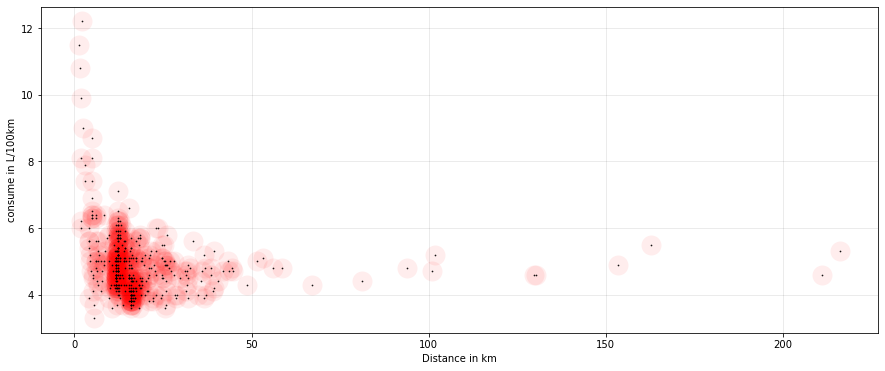

In [7]:
fig, axarr = plt.subplots()
fig.set_size_inches(w=15, h=6)
red_halo = (1., 0, 0, 0.07)

axarr.scatter(df.distance.values, df.consume.values, color=red_halo, s=400, marker='o',linewidths=0)
axarr.scatter(df.distance.values, df.consume.values, color='#000000', s=0.5, marker='o', alpha=.9)
axarr.grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
axarr.set_xlabel('Distance in km')
axarr.set_ylabel('consume in L/100km')

**Plot of outside temperature in °C vs consume in L/100km**
<br/>
This plot show the fuel consumption according to outside temprature.

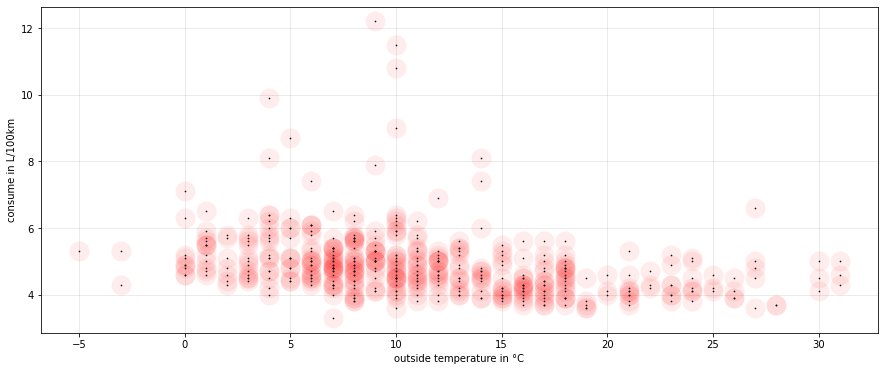

In [8]:
fig, axarr = plt.subplots()
fig.set_size_inches(w=15, h=6)
red_halo = (1., 0, 0, 0.07)

axarr.scatter(df.temp_outside.values, df.consume.values, color=red_halo, s=400, marker='o',linewidths=0)
axarr.scatter(df.temp_outside.values, df.consume.values, color='#000000', s=0.5, marker='o', alpha=.9)
axarr.grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
axarr.set_xlabel('outside temperature in °C')
text = axarr.set_ylabel('consume in L/100km')

Every datapoint has a red halo, so that one can see overlaps like on sort of a heat map.
<br/><br/>
Notably the distance has some outliers. I did this analysis with and without those outliers: The consumption prediction stays roughly the same; the difference is about +/- 0.1 L/100km. So for the moment i keep them - the weather gets better, so i might measure some more long distance "outliers" soon. :-) The way to work is 12 km long, so that's where that big blob comes from.
<br/><br/>
Just because i wanted to try it once, a 3D plot. Also i hope to spread my blob of commute traffic a little bit:

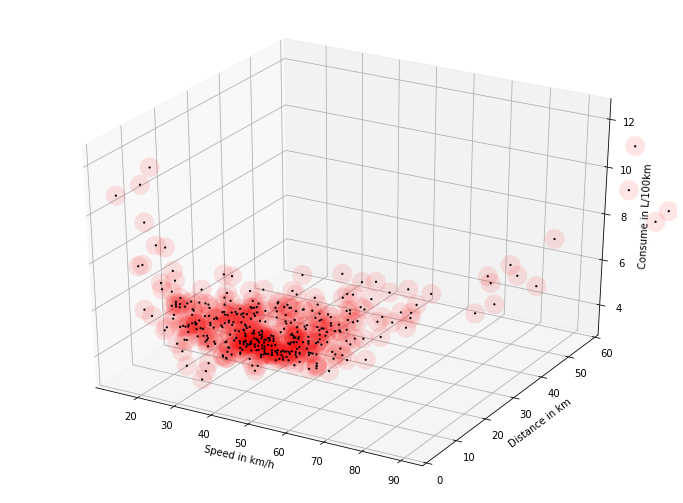

In [9]:
from mpl_toolkits.mplot3d import Axes3D
alpha = 0.1
fig = plt.figure()
fig.set_size_inches(w=12, h=9)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.speed.values, df.distance.values,  df.consume.values,  
           color='r', s=400, marker='o', alpha=alpha, linewidths=0)
ax.scatter(df.speed.values, df.distance.values,  df.consume.values,   
           color='#000000', s=5, marker='o', alpha=1, linewidths=0)


ax.set_xlabel('Speed in km/h')
ax.set_ylabel('Distance in km')
ax.set_ylim(0, 60) # exclude the two outliers from the graphic
text = ax.set_zlabel('Consume in L/100km')

Let's see what we can extract from that. I leave this code open as any failure here is important for the rest of the notebook...

In [10]:
# indicator if the heating was not used at all
df['heating_off']=df['temp_inside'].isnull()
df['heating_off']=df['heating_off'].apply(float)
# if the heating was turned completely off, replace the inside temperature by the outside temperature
df['temp_inside'].fillna(df['temp_outside'], inplace=True)
# get the temperature difference
df['temp_diff'] = df['temp_inside'] - df['temp_outside']
df['temp_diff_square'] = df['temp_diff']**2
# add the square and cube of the speed to the frame
df['speedsquare'] = df['speed']**2  # 5% better accuracy
df['speedcube'] =  df['speed']**3  # 1% better accuracy

# translate the gas type to something machine readable
def gastype(in_string):
    '''gas type in, integer out'''
    if in_string == "E10":
        return 0
    else:
        return 1
df['gas_type_num']= df['gas_type'].apply(gastype)
print(df.groupby(by='gas_type')['consume'].mean().round(2))

gas_type
E10     4.93
SP98    4.90
Name: consume, dtype: float64


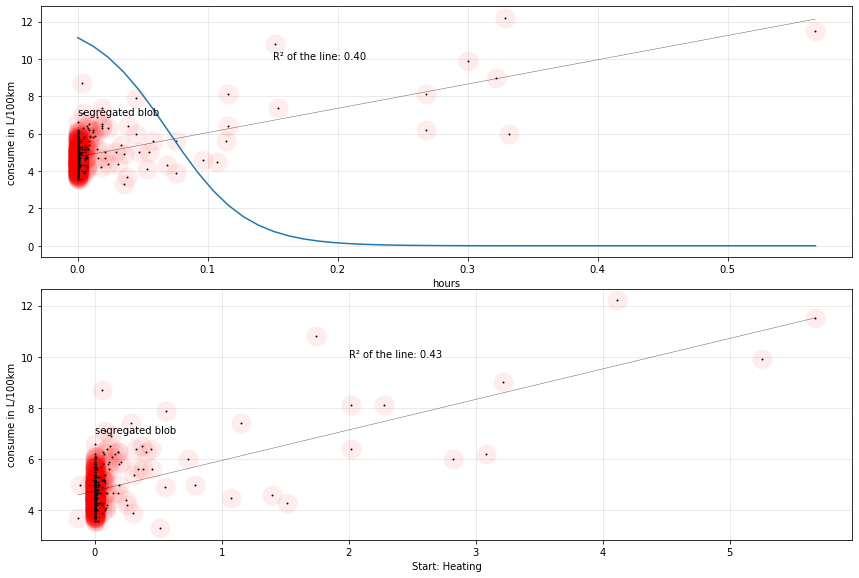

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from ipywidgets import *
# slope get down rather fast.
# delay: after 7% of an hour, equals 5 minutes, cut off.
def sigmo(x, slope = 33.5, delay = 0.07):
    return 1 / (1 + np.exp( (x-delay)* slope))

df['time_h'] = (df['distance']/df['speed'])
df['startphase'] = sigmo(df['time_h'])

#check the additional worth of it
rgr = LinearRegression()
rgr.fit(df.startphase.values.reshape(-1, 1), df.consume.values)
regression_fit = 'R² of the line: {:.2f}'.format(rgr.score(df.startphase.values.reshape(-1, 1), df.consume.values))

fig, axarr = plt.subplots(2,1)
fig.set_size_inches(w=12, h=8)
fig.tight_layout()
alpha = 0.05
# plot of startphase
line0, = axarr[0].plot(df.startphase.values,  df.startphase.values*rgr.coef_[0]+rgr.intercept_, 
                       color='#000000', alpha=.3, linewidth=0.5)
text0 = axarr[0].text(0.15, 10, regression_fit)
halo0 = axarr[0].scatter(df.startphase.values, df.consume.values, color=red_halo, s=400, marker='o',linewidths=0)
poin0 = axarr[0].scatter(df.startphase.values, df.consume.values, color='#000000', s=1, marker='o', alpha=.9)
x = np.linspace(0,df.startphase.values.max())
sigm0, = axarr[0].plot(x, sigmo(x)*df.consume.values.max())
axarr[0].grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
axarr[0].set_xlabel('hours')
axarr[0].set_ylabel('consume in L/100km')
axarr[0].text(0.0, 7, 'segregated blob')


# heating costs extra in the startphase, later not so much
df['start_heating'] = df['startphase'] * df['temp_diff'] 
#check the additional worth of it
rgr = LinearRegression()
rgr.fit(df.start_heating.values.reshape(-1, 1), df.consume.values)
regression_fit = 'R² of the line: {:.2f}'.format(rgr.score(df.start_heating.values.reshape(-1, 1), df.consume.values))

#plot of start_heating
line1, = axarr[1].plot(df.start_heating.values, df.start_heating.values*rgr.coef_[0]+rgr.intercept_, 
                       color='#000000', alpha=.3, linewidth=0.5)
text1 = axarr[1].text(2, 10, regression_fit)
halo1 = axarr[1].scatter(df.start_heating.values, df.consume.values, color=red_halo, s=400, marker='o',linewidths=0)
poin1 = axarr[1].scatter(df.start_heating.values, df.consume.values, color='#000000', s=1, marker='o', alpha=.9)
axarr[1].grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
axarr[1].set_xlabel('Start: Heating')
axarr[1].text(0, 7, 'segregated blob')
text = axarr[1].set_ylabel('consume in L/100km')

def update(slope, delay):
    df['startphase'] = sigmo(df['time_h'], slope=slope, delay=delay)
    rgr = LinearRegression()
    rgr.fit(df.startphase.values.reshape(-1, 1), df.consume.values)
    score = rgr.score(df.startphase.values.reshape(-1, 1), df.consume.values)
    #text0.set_position(0.4, 10)
    text0.set_text('R² of the line: {:.2f}'.format(score))
    line0.set_data(df.startphase.values, df.startphase.values*rgr.coef_[0]+rgr.intercept_)
    halo0.set_offsets(np.c_[df.startphase.values, df.consume.values])
    poin0.set_offsets(np.c_[df.startphase.values, df.consume.values])
    
    x = np.linspace(0,df.startphase.values.max())
    sigm0.set_data(x, sigmo(x, slope=slope, delay=delay)*df.consume.values.max())

    df['start_heating'] = df['startphase'] * df['temp_diff'] 
    #check the additional worth of it
    rgr = LinearRegression()
    rgr.fit(df.start_heating.values.reshape(-1, 1), df.consume.values)
    score = rgr.score(df.start_heating.values.reshape(-1, 1), df.consume.values)

    text1.set_text('R² of the line: {:.2f}'.format(score))
    line1.set_data(df.start_heating.values, df.start_heating.values*rgr.coef_[0]+rgr.intercept_)
    halo1.set_offsets(np.c_[df.start_heating.values, df.consume.values])
    poin1.set_offsets(np.c_[df.start_heating.values, df.consume.values])
    
    fig.canvas.draw()

def plot_interactive():
    slope_w = widgets.FloatSlider(description='slope', value=33.5, min=0, max=200, step=0.01, width=600,
                                 layout = Layout(width='60%', height='40px'))
    delay_w = widgets.FloatSlider(description='delay', value=0.070, min=0, max=0.2, step=0.001,
                                 layout = Layout(width='60%', height='40px'))
    interact(update, slope=slope_w, delay=delay_w)

fig.canvas.draw()

With that R² this artificial feature looks fairly good - as indicator for the consumption it works better than any other feature so far. Remarkable: The better this feature fits the data, the less the overconsumption of E10 looks...
<br/><br/>
Just to be complete, a short draw of the last features: Heating off, AC (clime), rain, sun. All three have a small but measurable impact...

**heating on (0) or off (1) vs consume in L/100km**
<br/>
This plot show the fuel consumption according to heat.

Text(0, 0.5, 'consume in L/100km')

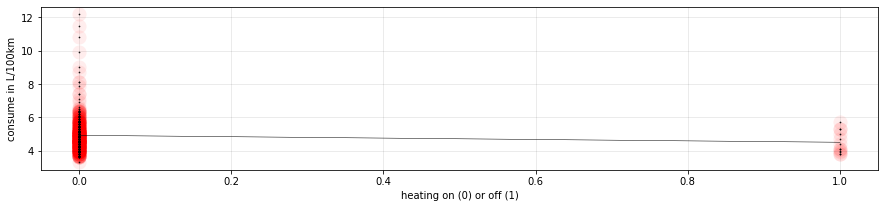

In [12]:
rgr = LinearRegression()
fig, ax = plt.subplots()
fig.set_size_inches(w=15, h=3)
X=np.array([0,1.])
# plot of speed
rgr.fit(df.heating_off.values.reshape(-1, 1), df.consume.values)
ax.plot(X,  X*rgr.coef_[0]+rgr.intercept_, color='#000000', alpha=1, linewidth=0.5)
ax.scatter(df.heating_off.values, df.consume.values, color=red_halo, s=200, marker='o', linewidths=0)
ax.scatter(df.heating_off.values, df.consume.values, color='#000000', s=0.5, marker='o', alpha=.9)
ax.grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
ax.set_xlabel('heating on (0) or off (1)')
ax.set_ylabel('consume in L/100km')

**AC off (0) or on (1) vs consume in L/100km!**
<br/>
This plot show the fuel consumption according to AC.

Text(0, 0.5, 'consume in L/100km')

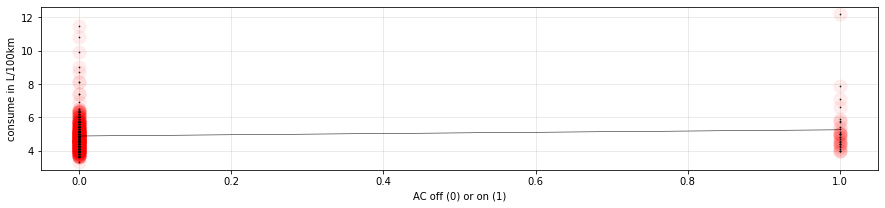

In [13]:
rgr = LinearRegression()
fig, ax = plt.subplots()
fig.set_size_inches(w=15, h=3)
X=np.array([0,1.])
rgr.fit(df.AC.values.reshape(-1, 1), df.consume.values)
ax.plot(X,  X*rgr.coef_[0]+rgr.intercept_, color='#000000', alpha=1, linewidth=0.5)
ax.scatter(df.AC.values, df.consume.values, color=red_halo, s=200, marker='o', linewidths=0)
ax.scatter(df.AC.values, df.consume.values, color='#000000', s=0.5, marker='o', alpha=.9)
ax.grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
ax.set_xlabel('AC off (0) or on (1)')
ax.set_ylabel('consume in L/100km')

**rain (1) or not (0) vs consume in L/100km**
<br/>
This plot show the fuel consumption according to rain.

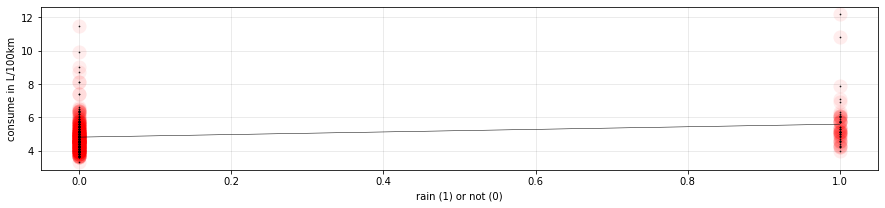

In [14]:
rgr = LinearRegression()
fig, ax = plt.subplots()
fig.set_size_inches(w=15, h=3)
X=np.array([0,1.])
rgr.fit(df.rain.values.reshape(-1, 1), df.consume.values)
ax.plot(X,  X*rgr.coef_[0]+rgr.intercept_, color='#000000', alpha=1, linewidth=0.5)
ax.scatter(df.rain.values, df.consume.values, color=red_halo, s=200, marker='o', linewidths=0)
ax.scatter(df.rain.values, df.consume.values, color='#000000', s=0.5, marker='o', alpha=.9)
ax.grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
ax.set_xlabel('rain (1) or not (0)')
text = ax.set_ylabel('consume in L/100km')

**no sun (0) or sun (1) vs consume in L/100km**
<br/>
This plot show the fuel consumption according to sun.

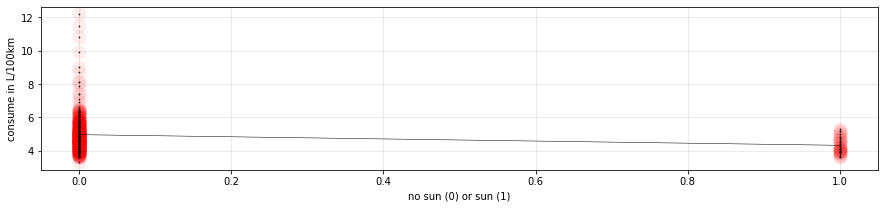

In [15]:
rgr = LinearRegression()
fig, ax = plt.subplots()
fig.set_size_inches(w=15, h=3)
X=np.array([0,1.])
rgr.fit(df.sun.values.reshape(-1, 1), df.consume.values)
ax.plot(X,  X*rgr.coef_[0]+rgr.intercept_, color='#000000', alpha=1, linewidth=0.5)
ax.scatter(df.sun.values, df.consume.values, color=red_halo, s=200, marker='o', linewidths=0)
ax.scatter(df.sun.values, df.consume.values, color='#000000', s=0.5, marker='o', alpha=.9)
ax.grid(color='#000000', linestyle='-', linewidth=1, alpha=0.08)
ax.set_xlabel('no sun (0) or sun (1)')
text = ax.set_ylabel('consume in L/100km')

**Correlation plot**
<br/>
Correlation between different features of our dataset.


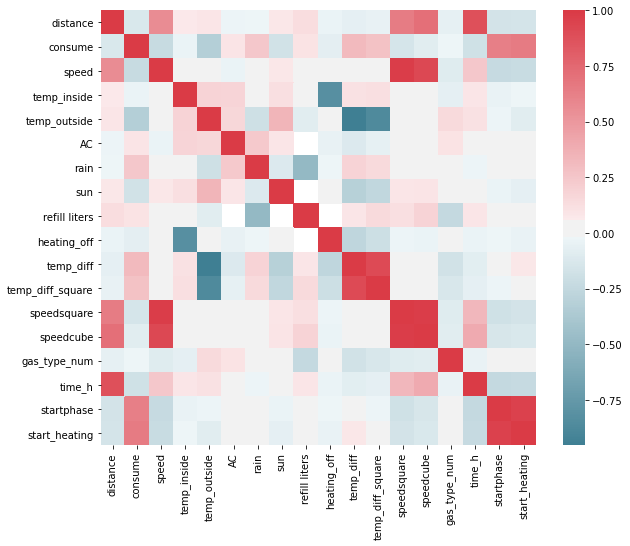

In [16]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)